# Lab3 - Training Deep Convolutional Neural Network
- Name1, Student's ID1
- Name2, Student's ID2

Name your file to (first 2 student ID digit)_(last 4 student ID digit)*4.ipynb

## Lab Instruction 

In this lab, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use  Cat vs Dog dataset.

See https://www.kaggle.com/c/dogs-vs-cats/data


### Your Turn! Dog or Cat Application 

Now, it time to put everything together and develop and Cat vs Dog classifier model. Assume that you and your company want to get more attraction on your product by launching a new product that can classify whether it is a dog or a cat. You have decide that you want a precision more than 90 - 95% in order to launch to product.

You have a cat and dog dataset contain total of 25000 images, 12500 for cat and other half for a dog.

After successfully develop this model, you can try to play with it to see how it perform. (You can upload your selfies image to see you are a dog or a cat)

Some note before start a project:
1. You have to load a data into a project using any method 
**suggest**
   

```
 !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
 !unzip -qq Cat_Dog_data.zip
```


2. You have to plan on how you will split a data. (or no need for suggest method)
3. You have to preprocess your data before feed into a network. For example, cropping, padding, etc.
4. You can come up with any model or use pre-train model. It depend on you!

You have two week for this project so that you can compete with your competitor app! Now, create a new Jupyter notebook and start building a model!

In [ ]:
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image 
from keras.datasets import fashion_mnist
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
from keras.layers.convolutional import  MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img

In [ ]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['acc'][-1])
    print('Last validation accuracy: %s'%history.history['val_acc'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features, verbose=True)
    #verbose เอาไว้แสดงสถานะตลอดเวลาว่าทำอะไรอยู่
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
   
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')
    
    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))
            
# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        
def deprocess_image(img):
    
    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    
    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)
            
            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)  

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
 !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
 !unzip -qq Cat_Dog_data.zip

--2022-03-21 19:04:51--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.143.8
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.143.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  77.2MB/s    in 8.0s    

2022-03-21 19:04:59 (69.3 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



In [ ]:
# move all images into Cat_Dog_data

!mv /content/Cat_Dog_data/test/cat/* /content/Cat_Dog_data
!mv /content/Cat_Dog_data/test/dog/* /content/Cat_Dog_data
!mv /content/Cat_Dog_data/train/cat/* /content/Cat_Dog_data
!mv /content/Cat_Dog_data/train/dog/* /content/Cat_Dog_data

In [ ]:
#path เพื่อดูว่ามีไฟล์อะไรบ้าง
print(os.listdir("/content/Cat_Dog_data"))

['cat.9074.jpg', 'cat.4819.jpg', 'cat.7649.jpg', 'cat.3465.jpg', 'cat.7059.jpg', 'cat.9740.jpg', 'cat.1212.jpg', 'cat.1302.jpg', 'dog.7808.jpg', 'cat.3881.jpg', 'dog.1716.jpg', 'dog.985.jpg', 'cat.5327.jpg', 'dog.10635.jpg', 'dog.9402.jpg', 'dog.11846.jpg', 'cat.10042.jpg', 'dog.11866.jpg', 'dog.10534.jpg', 'dog.1468.jpg', 'cat.12386.jpg', 'cat.10976.jpg', 'cat.12329.jpg', 'cat.3607.jpg', 'cat.2836.jpg', 'dog.2892.jpg', 'dog.2319.jpg', 'cat.3396.jpg', 'dog.2341.jpg', 'dog.1008.jpg', 'cat.8829.jpg', 'cat.4294.jpg', 'dog.6955.jpg', 'dog.375.jpg', 'dog.6012.jpg', 'dog.4551.jpg', 'cat.11415.jpg', 'dog.10283.jpg', 'dog.7713.jpg', 'cat.3273.jpg', 'cat.4690.jpg', 'cat.652.jpg', 'dog.913.jpg', 'cat.1467.jpg', 'cat.8998.jpg', 'cat.1504.jpg', 'dog.3975.jpg', 'dog.8171.jpg', 'dog.9872.jpg', 'cat.2843.jpg', 'dog.9974.jpg', 'cat.7196.jpg', 'cat.9413.jpg', 'cat.11225.jpg', 'dog.682.jpg', 'cat.12102.jpg', 'dog.772.jpg', 'cat.7989.jpg', 'cat.437.jpg', 'dog.7648.jpg', 'dog.3295.jpg', 'cat.1260.jpg', 'c

# Define Constants

In [ ]:
FAST_RUN = False
IMAGE_WIDTH=200
IMAGE_HEIGHT=200
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
batch_size= 64

#Prepare Traning Data

In [ ]:
filenames = os.listdir("/content/Cat_Dog_data")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head()

,filename,category
0,cat.11511.jpg,0
1,dog.38.jpg,1
2,cat.6400.jpg,0
3,dog.454.jpg,1
4,cat.10755.jpg,0


#See Sample

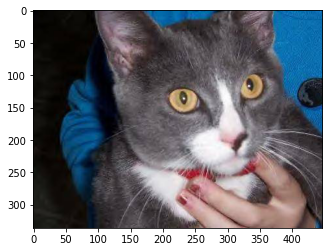

In [ ]:
import random
sample = random.choice(filenames)
image = load_img("/content/Cat_Dog_data/"+sample)
plt.imshow(image)

# Prepare data
Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [ ]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [ ]:
x = df['filename'].values
y = df['category'].values

In [ ]:
x[0]

'cat.11511.jpg'

In [ ]:
y[0]

'cat'

In [ ]:
# Split train test
train_df,test_df = train_test_split(df,test_size =0.3,stratify=y,random_state=0)
# Split train validate
train_df,validation_df = train_test_split(df,test_size =0.3,stratify=y,random_state=0)

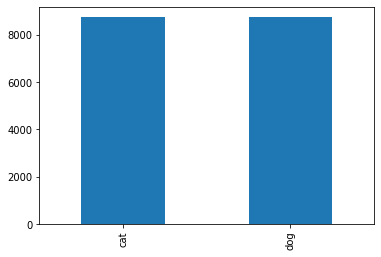

In [ ]:
train_df['category'].value_counts().plot.bar()

#Traning Generator

In [ ]:
 # declare imggen = ImageDataGenerator from Keras Preprocessing

image_datagen = ImageDataGenerator(rotation_range=15,
                                  rescale=1./255,
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1
                              )

train_set = image_datagen.flow_from_dataframe(train_df, "/content/Cat_Dog_data/", 
                                            x_col='filename',
                                            y_col='category',
                                            target_size=IMAGE_SIZE,
                                            class_mode='categorical',
                                            batch_size= batch_size )
                                          

Found 17500 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
test_df["category"] = test_df["category"].replace({0: 'cat', 1: 'dog'}) 

In [ ]:
image2_datagen = ImageDataGenerator( rescale=1./255 )
test_set = image2_datagen.flow_from_dataframe(test_df, "/content/Cat_Dog_data/", 
                                            x_col='filename',
                                            y_col='category',
                                            target_size=IMAGE_SIZE,
                                            class_mode='categorical',
                                            batch_size= batch_size,
                                            shuffle = False )

Found 7500 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


#Validation Generator

In [ ]:
validation_set = image_datagen.flow_from_dataframe(validation_df, "/content/Cat_Dog_data", 
                                                              x_col='filename',
                                                              y_col='category',
                                                              target_size = IMAGE_SIZE,
                                                              class_mode='categorical',
                                                              batch_size = batch_size )

Found 7501 validated image filenames belonging to 2 classes.


In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = image_datagen.flow_from_dataframe(example_df, 
                                                      "/content/Cat_Dog_data", 
                                                      x_col='filename',
                                                      y_col='category',
                                                      target_size=IMAGE_SIZE,
                                                      class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


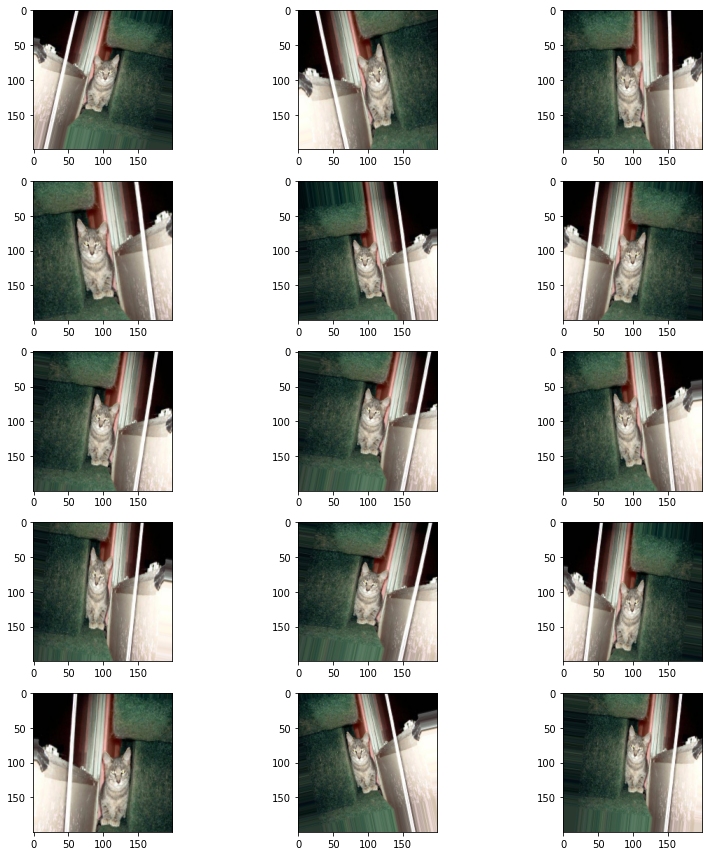

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Model

# Loading the VGG model using Transfer Learning
vgg16_model = VGG16(include_top = False, weights = 'imagenet',input_shape = (200,200,3))

# Freeze all layers in vgg16_model
for layer in vgg16_model.layers:
    layer.trainable = False

# Defining the output layers
flat = Flatten()(vgg16_model.layers[-1].output)
class1 = Dense(units = 256, activation='relu')(flat)
class2 = Dense(units = 256, activation = 'relu')(class1)
output = Dense(units = 2, activation='softmax')(class2)

# define new model
vgg16_model = Model(inputs=vgg16_model.inputs, outputs=output)
vgg16_model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['acc'])

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [ ]:
callbacks = [early_stop, learning_rate_reduction]

In [ ]:
history = vgg16_model.fit(train_set,  epochs= 20, batch_size = 64, validation_data= validation_set,  callbacks=[early_stop, learning_rate_reduction])
vgg16_model.save('vgg16_1.h5')


Epoch 1/20
274/274 [==============================] - 374s 1s/step - loss: 0.3042 - acc: 0.8719 - val_loss: 0.2344 - val_acc: 0.8983 - lr: 0.0010
Epoch 2/20
274/274 [==============================] - 352s 1s/step - loss: 0.2208 - acc: 0.9074 - val_loss: 0.2140 - val_acc: 0.9095 - lr: 0.0010
Epoch 3/20
274/274 [==============================] - 345s 1s/step - loss: 0.2043 - acc: 0.9134 - val_loss: 0.2223 - val_acc: 0.9027 - lr: 0.0010
Epoch 4/20
274/274 [==============================] - ETA: 0s - loss: 0.1994 - acc: 0.9155
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
274/274 [==============================] - 343s 1s/step - loss: 0.1994 - acc: 0.9155 - val_loss: 0.2121 - val_acc: 0.9048 - lr: 0.0010
Epoch 5/20
274/274 [==============================] - 353s 1s/step - loss: 0.1814 - acc: 0.9242 - val_loss: 0.1968 - val_acc: 0.9147 - lr: 5.0000e-04
Epoch 6/20
274/274 [==============================] - 362s 1s/step - loss: 0.1793 - acc: 0.9236 - val_loss: 0.

Last train accuracy: 0.9494256973266602
Last validation accuracy: 0.92227703332901


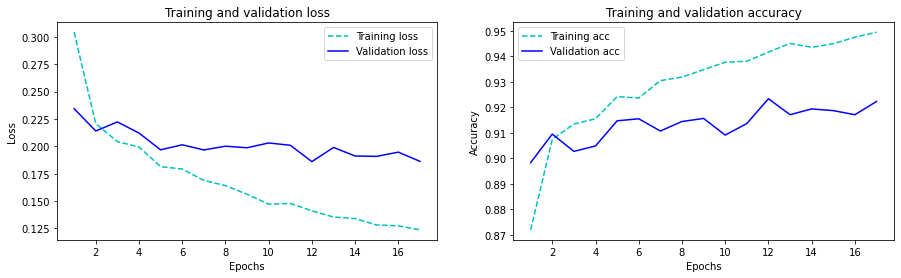

In [ ]:
show_result(history)

In [ ]:
test_df["category"] = test_df["category"].replace({'cat' : 0, 'dog' : 1}) 

In [ ]:
evaluation_report(vgg16_model, test_set , test_df['category'])

118/118 [==============================] - 58s 489ms/step - loss: 0.1594 - acc: 0.9367
[[3470  281]
 [ 194 3556]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3751
           1       0.93      0.95      0.94      3750

    accuracy                           0.94      7501
   macro avg       0.94      0.94      0.94      7501
weighted avg       0.94      0.94      0.94      7501

Loss: 0.15942952036857605 Accuracy: 0.9366751313209534


array([1, 1, 1, ..., 0, 1, 1])

In [ ]:
vgg16 = models.load_model('vgg16_1_early 5.h5')

In [37]:
pip install tensorflow

     |████████████████████████████████| 462 kB 4.5 MB/s 


In [38]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
# Helper libraries
import numpy as np
import matplotlib.pyplot as pl
print(tf.__version__)

2.8.0


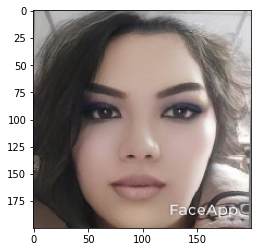

In [45]:
# load an image from file
img_path = "/content/solomon_folder/solomon_beauty.png"

img = image.load_img(img_path, target_size=(200, 200))
plt.imshow(img)
plt.show()

In [46]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

In [47]:
img_preprocessed = preprocess_input(img_batch)

In [48]:
vgg16 = models.load_model('vgg16_1_early 5.h5')

In [51]:
prediction = vgg16.predict(img_preprocessed).argmax(axis=1)

In [53]:
print(prediction)

[1]


In [32]:
!mkdir solomon_folder

In [36]:
image2_datagen = ImageDataGenerator( rescale=1./255 )
myimage = image2_datagen.flow_from_directory('/content/solomon_folder',
                                      batch_size = 64,
                                      target_size = (200,200))


Found 0 images belonging to 0 classes.
